In [102]:
import statsmodels.api as sm
import statsmodels.stats as stats
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.sm_exceptions import DomainWarning
import warnings
from patsy import dmatrix, dmatrices
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy import stats

from tabulate import tabulate

pd.set_option('display.precision', 3)

num_sites    2.428925e-09
Z_p          4.271022e-10
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:          num_mutations   No. Observations:                   14
Model:                            GLM   Df Residuals:                       12
Model Family:                 Poisson   Df Model:                            1
Link Function:               Identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42.800
Date:                Tue, 10 Dec 2024   Deviance:                       18.306
Time:                        14:45:07   Pearson chi2:                     18.8
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9830
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


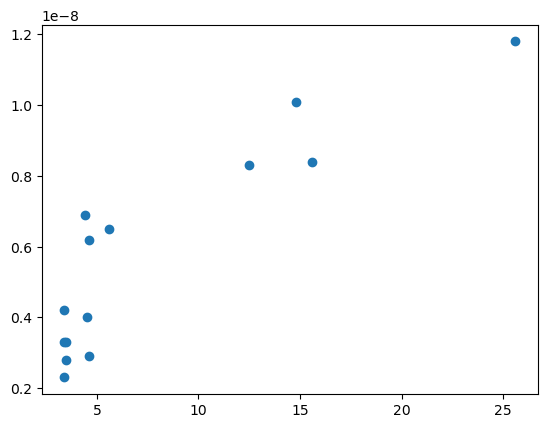

In [83]:
def sanity_check_poisson_regression():
    def poisson_helper(X, y, add_intercept=False):
        X = sm.add_constant(X) if add_intercept else X
        result = sm.GLM(y, X, family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()
        print(result.params)
        print(result.summary())
        # intercept, slope = result.params.const, result.params.paternal_age
        # print(f"intercept: {intercept:.2E}, slope: {slope:.2E}")

    filename = "./data/mutation_rate_individual_species/Rhesus_macaque_wang_2020.txt"
    col_header = ["maternal_age", "paternal_age", "haploid_size",  "num_mutations", "callability", "mu_per_site"]
    # use the GATK calls
    df = pd.read_csv(filename, sep=" ", skiprows=1, header=None, names=col_header, usecols=[1,2,3,4,5,6])
    df["haploid_size"] = df["haploid_size"] * 1e6
    df["mu_per_site"] *= 1e-8

    y = df["num_mutations"]
    df["num_sites"] = 2 * df["haploid_size"] * df["callability"]
    df["Z_p"] = df["num_sites"] * df["paternal_age"]
    # df["Z_m"] = df["num_sites"] * df["maternal_age"]
    X = df[["num_sites", "Z_p"]] #, "Z_m"]]
    poisson_helper(X, y)

    y = df["mu_per_site"]
    X = df[["paternal_age"]]
    poisson_helper(X, y, add_intercept=True)
    fig, ax = plt.subplots()
    X_min, X_max = 0, np.max(X)
    ax.scatter(X, y)

sanity_check_poisson_regression()
    

In [100]:
def compute_weighted_average_age_and_regression_covariates(paternal_age, maternal_age, callable_genome_size, age_of_puberty, paternal_maternal_ratio = [3, 1]):
    paternal_coeff, maternal_coeff = paternal_maternal_ratio
    denominator = np.sum(paternal_maternal_ratio)
    corrected_age = (paternal_coeff * paternal_age + maternal_coeff * maternal_age) / denominator - age_of_puberty

    Z_p = paternal_age * callable_genome_size
    Z_m = maternal_age * callable_genome_size
    Z_c = corrected_age * callable_genome_size
    return [corrected_age, Z_p, Z_m, Z_c]

def load_rhesus_macaque_wang_2020_data():
    age_of_puberty = 3.5

    filename = "./data/mutation_rate_individual_species/Rhesus_macaque_wang_2020.txt"
    col_header = ["maternal_age", "paternal_age", "haploid_size", "mutation_count", "callability"]
    # use the GATK calls
    df = pd.read_csv(filename, sep=" ", skiprows=1, header=None, names=col_header, usecols=[1,2,3,4,5])
    df["haploid_size"] *= 1e6
    df["callable_genome_size"] = 2 * df["haploid_size"] * df["callability"] 
    df["species"] = "Rhesus macaque"
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), age_of_puberty)
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

def load_owl_monkey_data():
    age_of_puberty = 1
    false_negative_rate = 0.437634344
    filename = "./data/mutation_rate_individual_species/Owl_monkey_thomas_2018.xlsx"
    df = pd.read_excel(filename, sheet_name="DataS1C-rates", skiprows=[0,1], nrows=15)
    rename_map = {"Paternal age": "paternal_age", "Maternal age": "maternal_age", "Mutations": "mutation_count"}
    df = df.rename(columns=rename_map)
    df["mutation_count"] = np.round(df["mutation_count"] / false_negative_rate)
    df["callable_genome_size"] = 2 * (df["Total sites"] - df["Filtered SNP sites"])
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), age_of_puberty)
    # y, X = df["mutation_count"], df[["callable_genome_size", "Z_p"]]
    # y, X = df["Mutation rate"], sm.add_constant(df[["paternal_age"]])
    # model = OLS(y, X).fit()
    # print(model.summary())
    df["species"] = "Owl_monkey"
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

def load_lindsay_mouse_data():
    age_of_puberty = 0.15
    genome_size = 2222635788

    filename = "./data/mutation_rate_individual_species/lindsay_mouse_mutation_counts.txt"
    col_header = ["mouse_id", "mutation_count", "age_week"]
    df = pd.read_csv(filename, sep=" ", header=None, names=col_header, usecols=[0, 5, 8], index_col=[0])
    df["callable_genome_size"] = 2 * genome_size
    df["age_year"] = df["age_week"] / 52
    df["paternal_age"] = df["age_year"]
    df["maternal_age"] = df["age_year"]
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), age_of_puberty)
    df["species"] = "Mouse"
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

def poisson_regression_for_individual_species(y, X, add_intercept=False):
    X = sm.add_constant(X) if add_intercept else X
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DomainWarning)
        result = sm.GLM(y, X, family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()
        
    params, pvals, conf_int = result.params, result.pvalues, result.conf_int()
    conf_int.columns = ["lower", "upper"]
    df_result = pd.concat([params.rename("coeff"), pvals.rename("pval"), conf_int], axis=1)
    print(df_result)

df_macaque = load_rhesus_macaque_wang_2020_data()
df_mouse = load_lindsay_mouse_data()
df_owl_monkey = load_owl_monkey_data()

print("------ mouse -----")
poisson_regression_for_individual_species(df_mouse["mutation_count"], df_mouse[["callable_genome_size", "Z_p"]])
print("\n---- macaque ----")
poisson_regression_for_individual_species(df_macaque["mutation_count"], df_macaque[["callable_genome_size", "Z_p"]])
poisson_regression_for_individual_species(df_macaque["mutation_count"], df_macaque[["callable_genome_size", "Z_c"]])
print("\n---- owl monkey ----")
poisson_regression_for_individual_species(df_owl_monkey["mutation_count"], df_owl_monkey[["callable_genome_size", "Z_p"]])

------ mouse -----
                          coeff       pval      lower      upper
callable_genome_size  3.852e-09  1.602e-40  3.286e-09  4.419e-09
Z_p                   1.512e-09  5.748e-03  4.390e-10  2.585e-09

---- macaque ----
                          coeff       pval      lower      upper
callable_genome_size  2.429e-09  5.593e-07  1.478e-09  3.380e-09
Z_p                   4.271e-10  2.931e-11  3.012e-10  5.530e-10
                          coeff       pval      lower      upper
callable_genome_size  3.702e-09  2.819e-24  2.988e-09  4.416e-09
Z_c                   4.995e-10  9.025e-11  3.485e-10  6.506e-10

---- owl monkey ----
                          coeff       pval      lower      upper
callable_genome_size  5.050e-09  1.752e-05  2.745e-09  7.355e-09
Z_p                   8.181e-10  4.022e-06  4.703e-10  1.166e-09


In [107]:
def calculate_nested_f_statistic(small_model, big_model):
    """
        Given two fitted GLMs, the larger of which contains the parameter space of the smaller, 
        return the F Stat and P value corresponding to the larger model adding explanatory power
        from link: https://stackoverflow.com/questions/27328623/anova-test-for-glm-in-python
    """
    addtl_params = big_model.df_model - small_model.df_model
    f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = stats.f.sf(f_stat, df_numerator, df_denom)
    return (f_stat, p_value)

def poisson_regression_for_all_species(df, add_intercept=False, use_corrected_age=False):
    def regression_helper(y, X):
        column_names = X.design_info.column_names
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=DomainWarning)
            result = sm.GLM(y, X, family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()
        params, pvals, conf_int = list(result.params), list(result.pvalues), result.conf_int()
        table = [["coeff"] + params, ["p-value"] + pvals]
        print(tabulate(table, headers=column_names))
        print(f"AIC: {result.aic:.2f}")
        return result

    Z = "Z_c" if use_corrected_age else "Z_p"

    print("---- no category interactions ----")
    y = df["mutation_count"]
    X = dmatrix(f"0 + callable_genome_size + {Z}", df)
    result_no_category = regression_helper(y, X)

    print("---- vary everything ----")
    y = df["mutation_count"]
    X = dmatrix(f"0 + callable_genome_size + {Z} + C(species):callable_genome_size + C(species):{Z}", df)
    result_category_all = regression_helper(y, X)
    
    print("\n---- vary intercept ----")
    y = df["mutation_count"]
    X = dmatrix(f"0 + callable_genome_size + {Z} + C(species):callable_genome_size", df)
    result_category_intercept = regression_helper(y, X)

    print("\n---- vary slope ----")
    y = df["mutation_count"]
    X = dmatrix(f"0 + callable_genome_size + {Z} + C(species):{Z}", df)
    result_category_slope = regression_helper(y, X)

    f_stat, p_val = calculate_nested_f_statistic(result_no_category, result_category_all)
    print(f"\n-----------------------")
    print(f"ANOVA test, f statistic: {f_stat:.2f}, p-value: {p_val:.2E}")

df_all_species = pd.concat([df_macaque, df_mouse, df_owl_monkey], axis=0)
print(df_all_species["species"].value_counts())
poisson_regression_for_all_species(df_all_species, use_corrected_age=True)


species
Mouse             40
Rhesus macaque    14
Owl_monkey        14
Name: count, dtype: int64
---- no category interactions ----
           callable_genome_size          Z_c
-------  ----------------------  -----------
coeff              4.3066e-09    8.09165e-10
p-value            7.80413e-175  1.85709e-46
AIC: 530.39
---- vary everything ----
           callable_genome_size    C(species)[T.Owl_monkey]:callable_genome_size    C(species)[T.Rhesus macaque]:callable_genome_size          Z_c    C(species)[T.Owl_monkey]:Z_c    C(species)[T.Rhesus macaque]:Z_c
-------  ----------------------  -----------------------------------------------  ---------------------------------------------------  -----------  ------------------------------  ----------------------------------
coeff               4.07904e-09                                      1.89624e-09                                         -3.76751e-10  1.51212e-09                    -7.09159e-10                        -1.01258e-09
p-val

In [54]:



def load_basenbacher_data():
    age_of_puberty = 14 # {"Chimpanzee": 14, "Gorilla":, "Orangutan":}
    filename = "./data/mutation_rate_individual_species/Great_ape_basenbacher_2019.txt"
    col_header = ["species", "paternal_age", "maternal_age", "mu_per_site"]
    df = pd.read_csv(filename, sep=" ", header=None, names=col_header, usecols=[1,2,3,9]) #, nrows=2)
    df_chimp = df.loc[df["species"] == "Chimpanzee"]
    df_chimp["corrected_age"] = (df["paternal_age"] * 3 + df["maternal_age"]) / 4 - age_of_puberty

    # for sp, age_p in age_of_puberty.items():
    #     df.loc[df["species"] == sp, "corrected_age"] = (df["paternal_age"] * 3 + df["maternal_age"]) / 4 - age_p
    return df_chimp

def load_lindsay_mouse_data():
    age_of_puberty = 0.15
    filename = "./data/mutation_rate_individual_species/lindsay_mouse_mutation_counts.txt"
    col_header = ["mouse_id", "count", "age_week"]
    genome_size = 2222635788 
    df = pd.read_csv(filename, sep=" ", header=None, names=col_header, usecols=[0, 5, 8], index_col=[0])
    df["age_year"] = df["age_week"] / 52
    df["paternal_age"] = df["age_year"]
    df["maternal_age"] = df["age_year"]
    df["mu_per_site"] = df["count"] / (genome_size * 2)
    df["species"] = "Mouse"
    df["corrected_age"] = (df["paternal_age"] * 3 + df["maternal_age"]) / 4 - age_of_puberty
    return df[["species", "paternal_age", "maternal_age", "corrected_age", "mu_per_site"]]

# def create_paternal_maternal_age_column(group):
#     if group["Parent"] == "Pat":
# 
#     elif group["Parent"] == "Mat":


def group_rows_wu_2020_helper(df, genome_size, species_name, age_of_puberty):
    output_dict = defaultdict(dict)
    for idx, row in df.iterrows():
        individual = row["F1"]
        if row["Parent"] == "Pat":
            output_dict[individual]["paternal_age"] = row["age"]
            output_dict[individual]["paternal_count"] = row["dnm"]
        elif row["Parent"] == "Mat":
            output_dict[individual]["maternal_age"] = row["age"]
            output_dict[individual]["maternal_count"] = row["dnm"]
    maternal_missing = [] 
    for individual, val in output_dict.items():
        val["individual"] = individual
        if "maternal_count" not in val:
            maternal_missing.append(individual)
            continue
        val["mutation_count"] = val["paternal_count"] + val["maternal_count"]
        val["mu_per_site"] = val["mutation_count"] / genome_size
        val["corrected_age"] = (3 * val["paternal_age"] + val["maternal_age"]) / 4 - age_of_puberty
    print(f"there are {len(maternal_missing)} {species_name} missing maternal count")


    # mu_site_gen_human = mu_site_gen_human = compute_average_per_generation_per_site_mutation_rate(
    #     human_genome_size, df_human_group, paternal_gen_time_human, maternal_gen_time_human)
    # print(f"average mutation rate per site per generation for humans is {np.mean(mu_site_gen_human)}")
    for m in maternal_missing:
        _ = output_dict.pop(m)
    df_group = pd.DataFrame(output_dict.values())
    df_group["species"] = species_name
    return df_group[["species", "paternal_age", "maternal_age", "corrected_age", "mu_per_site"]]

def compute_average_per_generation_per_site_mutation_rate(genome_size, df, paternal_generation_time, maternal_generation_time):
    paternal_count, maternal_count = df["paternal_count"].to_numpy(), df["maternal_count"].to_numpy()
    paternal_age, maternal_age = df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy()
    paternal_rate_per_site_per_gen = paternal_count / paternal_age * paternal_generation_time / genome_size
    maternal_rate_per_site_per_gen = maternal_count / maternal_age * maternal_generation_time / genome_size
    mutation_rate_per_site_per_gen = (paternal_rate_per_site_per_gen + maternal_rate_per_site_per_gen) / 2
    return mutation_rate_per_site_per_gen

def load_baboon_human_wu_2020_data():
    # does the aye-aye paper plot the paternally phased number of mutations (what is the unit on the y-axis)
    human_genome_size, baboon_genome_size = 2881033286, 2581196250
    age_of_puberty_human, age_of_puberty_baboon = 13, 5.4
    paternal_gen_time_human, maternal_gen_time_human = 32, 28.2
    paternal_gen_time_baboon, maternal_gen_time_baboon = 10.7, 10.2

    filename =  "./data/mutation_rate_individual_species/baboon_wu_2020/baboon_wu_2020_S2_data.xlsx"

    df_human = pd.read_excel(filename, sheet_name="Fig 2A", skiprows=[0], nrows=21)
    df_human_group = group_rows_wu_2020_helper(df_human, human_genome_size, "Human", age_of_puberty_human)
    # print(df_human_group.head())

    df_baboon = pd.read_excel(filename, sheet_name="Fig 2B", skiprows=[0], nrows=23)
    df_baboon_group = group_rows_wu_2020_helper(df_baboon, baboon_genome_size, "Baboon", age_of_puberty_baboon)
    # mu_site_gen_baboon = compute_average_per_generation_per_site_mutation_rate(
    #     baboon_genome_size, df_baboon_group, paternal_gen_time_baboon, maternal_gen_time_baboon)
    # print(f"average mutation rate per site per generation for baboons is {np.mean(mu_site_gen_baboon)}")
    # print(df_baboon_group.head())
    return [df_human_group, df_baboon_group]
        

df_basen = load_basenbacher_data()
[df_human, df_baboon] = load_baboon_human_wu_2020_data()
df_mouse = load_lindsay_mouse_data()
df_owl_monkey = load_owl_monkey_data()
df = pd.concat([df_owl_monkey, df_basen, df_human, df_baboon, df_mouse])
print(df["species"].value_counts())

for species in df["species"].unique():
    df_s = df.loc[df["species"] == species]
    assert not df_s['mu_per_site'].isna().any()
    assert not df_s['corrected_age'].isna().any()

# df_rm_wang_2020 = load_rhesus_macaque_wang_2020_data()


there are 0 Human missing maternal count
there are 2 Baboon missing maternal count
species
Mouse         40
Owl_monkey    14
Human         10
Baboon        10
Chimpanzee     7
Name: count, dtype: int64


/var/folders/_t/8kf_5f6n7cz152sgc0n50bgh0000gn/T/ipykernel_6829/759859669.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chimp["corrected_age"] = (df["paternal_age"] * 3 + df["maternal_age"]) / 4 - age_of_puberty


In [49]:
def perform_poisson_regression_individually(df):
    species = df["species"].unique()
    for s in species:
        df_s = df.loc[df["species"] == s]
        y = df_s["mu_per_site"]
        X = df_s.drop(["mu_per_site", "species", "paternal_age", "maternal_age"], axis=1)
        X_intercept = sm.add_constant(X)
        result = sm.GLM(y, X_intercept, 
                                 family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()
        print(f"--------- {s} ---------------")
        print(result.summary())

perform_poisson_regression_individually(df)



--------- Owl_monkey ---------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:            mu_per_site   No. Observations:                   14
Model:                            GLM   Df Residuals:                       12
Model Family:                 Poisson   Df Model:                            1
Link Function:               Identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1692e-06
Date:                Mon, 09 Dec 2024   Deviance:                   1.1308e-08
Time:                        21:50:34   Pearson chi2:                 1.19e-08
No. Iterations:                     1   Pseudo R-squ. (CS):          2.212e-10
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const    

/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfe

species
Mouse         40
Owl_monkey    14
Baboon        10
Chimpanzee     7
Name: count, dtype: int64
                 Generalized Linear Model Regression Results                  
Dep. Variable:            mu_per_site   No. Observations:                   71
Model:                            GLM   Df Residuals:                       66
Model Family:                 Poisson   Df Model:                            4
Link Function:               Identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.4726e-06
Date:                Mon, 09 Dec 2024   Deviance:                   3.0640e-08
Time:                        15:12:37   Pearson chi2:                 3.19e-08
No. Iterations:                     1   Pseudo R-squ. (CS):          1.302e-09
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfe

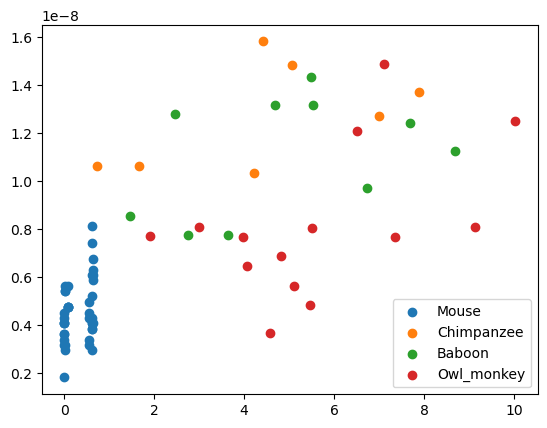

In [46]:
def perform_poisson_regression(df):
    # "Mouse"
    species_keep = ["Mouse", "Chimpanzee", "Baboon", "Owl_monkey"]
    df = df.loc[df["species"].isin(species_keep)] #, "Chimpanzee", "Gorilla"])]
    print(df["species"].value_counts())
    df_dummy = pd.concat((
        df, pd.get_dummies(data=df["species"], dtype='int', drop_first=True)), axis=1
        )
    y = df["mu_per_site"]
    X_category = df_dummy.drop(["mu_per_site", "species", "paternal_age", "maternal_age"], axis=1)
    X_nocategory = df[["corrected_age"]]
    X_c_intercept = sm.add_constant(X_category)
    X_noc_intercept = sm.add_constant(X_nocategory)
    result_category = sm.GLM(y, X_c_intercept, family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()
    result_nocategory = sm.GLM(y, X_noc_intercept, family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()

    # result = sm.GLM("mu_per_site")
    print(result_category.summary())
    print(result_nocategory.summary())
    
    # print(stats.anova.anova_lm(result_category, result_nocategory))
    
    fig, ax = plt.subplots()
    for s in species_keep:
        df_s = df.loc[df["species"] == s]
        ax.scatter(df_s["corrected_age"], df_s["mu_per_site"], label=s)
    ax.legend()
    # result = sm.OLS(y, X).fit()
    # intercept, slope = result.params.Intercept, result.params.age_year
    # print(intercept, slope)
    # print(results.coef, results.stderr)

    # fitted_values = result.fittedvalues
    # mutation count ~ time
    # y = data[]
    # sm.GLM(
    #     data[:,0], 
    #     offset=,
    #     family=sm.families.Poisson())
    # return intercept, slope, fitted_values
perform_poisson_regression(df)

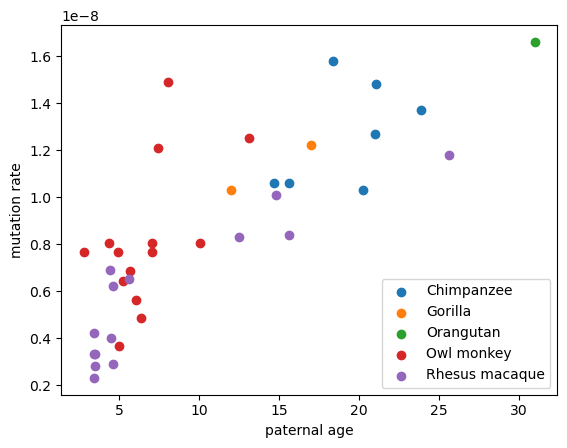

In [42]:
def plot_mutation_data(df):
    # first column mutation count, second column age
    # [intercept, slope, fitted_values] = perform_poisson_regression(df)
    fig, ax = plt.subplots(1, 1)
    species = df["species"].unique()
    for s in species:
        df_s = df[df["species"] == s]
        ax.scatter(df_s["paternal_age"], df_s["mutation_rate"], label=s)
    
    # ax.scatter(df["age_year"], df["count"])
    # xmin, xmax = np.min(df["age_year"]), np.max(df["age_year"])
    # x = np.linspace(xmin, xmax, 100)
    # y_predict = intercept + slope * x
    # ax.scatter(x, y_predict)
    ax.set_xlabel("paternal age")
    ax.set_ylabel("mutation rate")
    ax.legend()
plot_mutation_data(df)

17.124157770969063 6.721796755266026


/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


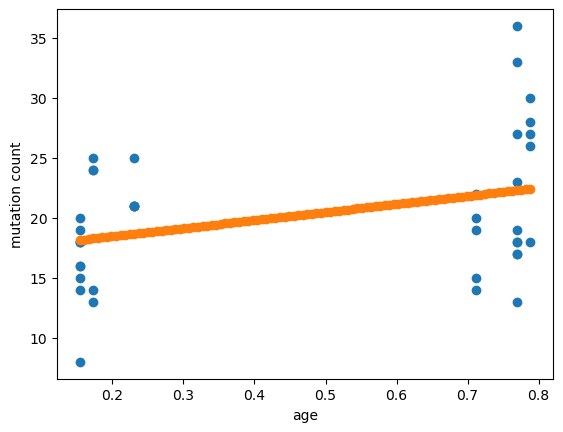

In [8]:
def plot_mutation_data(df):
    # first column mutation count, second column age
    [intercept, slope, fitted_values] = perform_poisson_regression(df)
    fig, ax = plt.subplots(1, 1)
    ax.scatter(df["age_year"], df["count"])
    xmin, xmax = np.min(df["age_year"]), np.max(df["age_year"])
    x = np.linspace(xmin, xmax, 100)
    y_predict = intercept + slope * x
    ax.scatter(x, y_predict)
    # ax.scatter(df["age_year"], fitted_values)
    # ax.axline((0, intercept), slope=slope)
    ax.set_xlabel("age")
    ax.set_ylabel("mutation count")

def perform_poisson_regression(df):
    expr = "count ~ age_year"
    y, X = dmatrices(expr, df, return_type="dataframe")
    result = sm.GLM(y, X, family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()
    # result = sm.OLS(y, X).fit()
    intercept, slope = result.params.Intercept, result.params.age_year
    print(intercept, slope)
    # print(results.coef, results.stderr)

    fitted_values = result.fittedvalues
    # mutation count ~ time
    # y = data[]
    # sm.GLM(
    #     data[:,0], 
    #     offset=,
    #     family=sm.families.Poisson())
    return intercept, slope, fitted_values
mouse_df = load_lindsay_mouse_data()
plot_mutation_data(mouse_df)
